# Projet Lichess

_Traitements et données large échelle_

Zoé Marquis & Charlotte Kruzic

TODO : présenter les objectifs du projet, les différentes questions, les données utilisées


### Installation et importation des bibliothèques nécessaires

In [1]:
!pip install kagglehub

In [2]:
!pip install -q findspark

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import kagglehub

import findspark
from pyspark.sql import SparkSession

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [5]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"  # this is proper to Colab


## Préparation des données

Chargement des données, analyse exploratoire et prétraitement des données.

In [6]:
path = kagglehub.dataset_download("noobiedatascientist/lichess-september-2020-data")
print("Chemin vers le fichier du dataset : ", path)

Chemin vers le fichier du dataset :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3


In [7]:
files = os.listdir(path)
print("Fichiers du dataset : ", files)

Fichiers du dataset :  ['Sept_20_analysis.RDS', 'Sept_20_analysis.csv', 'Column information.txt']


In [8]:
filename = f"{path}/Sept_20_analysis.csv"
print("Nom du fichier : ", filename)

Nom du fichier :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Sept_20_analysis.csv


In [9]:
# voir le contenu du .txt
filename_txt = f"{path}/Column information.txt"
with open(filename_txt, 'r') as f:
    print(f.read())

GAME: Game ID (not from lichess.org)

BlackElo: Elo rating of the player with the black pieces

BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces

Date: Date the game was played

ECO: Game opening (ECO notation)

Event: Event where the game was played

Opening: Game opening

Result: Result of the game

	1-0 -- White victory
	0-1 -- Black victory
	1/2-1/2 -- Draw
	* -- Undecided
	
Site: URL of the game

Termination: Way the game terminated

	Time forfeit -- One of the players ran out of time
	Normal -- Game terminated with check mate
	Rules infraction -- Game terminated due to rule breaking
	Abandoned -- Game was abandoned
	
TimeControl: Timecontrol in seconds that was used for the game (Starting time: Increment) 

UTCTime: Time the game was played

WhiteElo: Elo rating of the player with the white pieces

WhiteRatingDiff: Rating change (gain/loss) after game conclusion for the player with the white pieces

Black_elo_category: ELO cate

## Spark

In [10]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [11]:
sc = spark.sparkContext
df_spark = spark.read.csv(filename, header=True, inferSchema=True)

In [12]:
df_spark.printSchema()

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

In [13]:
df_spark.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

## Question 1

Q1: What is the rate of blunders, errors and inaccuracies per move, per level category (*) and on Blitz type games (Blitz type is by far the most played on these online sites). A game has two players, whose ELOs are most likely different. You will be able to classify a game into a category, either by considering the average ELO of both players, or by considering only the games where both players are in the same category.

In [14]:
from pyspark.sql.functions import col, when, isnull

In [15]:
# Filtre les parties avec un type de jeu Blitz
df_blitz = df_spark.filter(col("Game_type") == "Blitz")

#### Calcule des taux

In [16]:
# Calcule taux de bourdes
df_blitz = df_blitz.withColumn("Black_blunders_rate", col("Black_blunders") / col("Total_moves")) \
                   .withColumn("White_blunders_rate", col("White_blunders") / col("Total_moves"))

In [17]:
# Calcule taux d'erreurs
df_blitz = df_blitz.withColumn("Black_errors_rate", col("Black_mistakes") / col("Total_moves")) \
                   .withColumn("White_errors_rate", col("White_mistakes") / col("Total_moves"))

In [18]:
# Calcule taux d'imprecisions
df_blitz = df_blitz.withColumn("Black_inaccuracies_rate", col("Black_inaccuracies") / col("Total_moves")) \
                   .withColumn("White_inaccuracies_rate", col("White_inaccuracies") / col("Total_moves"))

In [19]:
df_blitz.show(5)

+----+--------+---------------+----------+---+--------------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+--------------------+--------------------+--------------------+--------------------+-----------------------+-----------------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|               Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_ty

#### Calcule des catégories

In [20]:
# TODO : Peut etre différencier les others (ceux supérieur ou inférieur aux bornes) ??

# Ajout des catégories ELO
# Catégorie ELO du joueur Noir
df_blitz = df_blitz.withColumn("Black_ELO_category",
                              when((col("BlackElo") >= 1200) & (col("BlackElo") <= 1499), "occasional player")
                              .when((col("BlackElo") >= 1500) & (col("BlackElo") <= 1799), "good club player")
                              .when((col("BlackElo") >= 1800) & (col("BlackElo") <= 1999), "very good club player")
                              .when((col("BlackElo") >= 2000) & (col("BlackElo") <= 2399), "national and international level")
                              .when((col("BlackElo") >= 2400) & (col("BlackElo") <= 2800), "GMI, World Champions")
                              .otherwise("other")
                              )

# Catégorie ELO du joueur Blanc
df_blitz = df_blitz.withColumn("White_ELO_category",
                              when((col("WhiteElo") >= 1200) & (col("WhiteElo") <= 1499), "occasional player")
                              .when((col("WhiteElo") >= 1500) & (col("WhiteElo") <= 1799), "good club player")
                              .when((col("WhiteElo") >= 1800) & (col("WhiteElo") <= 1999), "very good club player")
                              .when((col("WhiteElo") >= 2000) & (col("WhiteElo") <= 2399), "national and international level")
                              .when((col("WhiteElo") >= 2400) & (col("WhiteElo") <= 2800), "GMI, World Champions")
                              .otherwise("other")
                              )

# Catégorie ELO moyenne des 2 joueurs
df_blitz = df_blitz.withColumn("Avg_ELO_category", (col("BlackElo") + col("WhiteElo")) / 2)

df_blitz = df_blitz.withColumn("Avg_ELO_category",
                              when((col("Avg_ELO_category") >= 1200) & (col("Avg_ELO_category") <= 1499), "occasional player")
                              .when((col("Avg_ELO_category") >= 1500) & (col("Avg_ELO_category") <= 1799), "good club player")
                              .when((col("Avg_ELO_category") >= 1800) & (col("Avg_ELO_category") <= 1999), "very good club player")
                              .when((col("Avg_ELO_category") >= 2000) & (col("Avg_ELO_category") <= 2399), "national and international level")
                              .when((col("Avg_ELO_category") >= 2400) & (col("Avg_ELO_category") <= 2800), "GMI, World Champions")
                              .otherwise("other"))

In [38]:
# vérifier combien de "other"
df_blitz.filter(col("Black_ELO_category") == "other").count()

241846

In [39]:
df_blitz.filter(col("White_ELO_category") == "other").count()

243617

#### Classification des games avec moyenne des 2 joueurs

In [23]:
df_avg_elo_summary = df_blitz.groupBy("Avg_ELO_category").agg(
    {"Black_blunders": "avg", "White_blunders": "avg",
     "Black_mistakes": "avg", "White_mistakes": "avg",
     "Black_inaccuracies": "avg", "White_inaccuracies": "avg",
     "Total_moves": "avg"}
).withColumnRenamed("avg(Black_blunders)", "Avg_Black_Blunders") \
 .withColumnRenamed("avg(White_blunders)", "Avg_White_Blunders") \
 .withColumnRenamed("avg(Black_mistakes)", "Avg_Black_Mistakes") \
 .withColumnRenamed("avg(White_mistakes)", "Avg_White_Mistakes") \
 .withColumnRenamed("avg(Black_inaccuracies)", "Avg_Black_Inaccuracies") \
 .withColumnRenamed("avg(White_inaccuracies)", "Avg_White_Inaccuracies") \
 .withColumnRenamed("avg(Total_moves)", "Avg_Total_Moves")

In [24]:
df_avg_elo_summary_pandas = df_avg_elo_summary.toPandas()

In [25]:
df_avg_elo_summary_pandas.isna().sum()

,0
Avg_ELO_category,0
Avg_White_Mistakes,0
Avg_White_Blunders,0
Avg_Black_Inaccuracies,0
Avg_Black_Mistakes,0
Avg_White_Inaccuracies,0
Avg_Black_Blunders,0
Avg_Total_Moves,0


In [26]:
# TODO : Voir si on affiche les other

# Ordonner les catégories de joueurs
category_order = ["other", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions"]
df_avg_elo_summary_pandas['Avg_ELO_category'] = pd.Categorical(df_avg_elo_summary_pandas['Avg_ELO_category'],  categories=category_order,  ordered=True)
df_avg_elo_summary_pandas = df_avg_elo_summary_pandas.sort_values('Avg_ELO_category')


categories = df_avg_elo_summary_pandas['Avg_ELO_category']
error_types = ['Bourdes', 'Erreurs', 'Imprecisions']

# Données par type d'erreur et catégorie
blunders = df_avg_elo_summary_pandas[['Avg_Black_Blunders', 'Avg_White_Blunders']].mean(axis=1)
mistakes = df_avg_elo_summary_pandas[['Avg_Black_Mistakes', 'Avg_White_Mistakes']].mean(axis=1)
inaccuracies = df_avg_elo_summary_pandas[['Avg_Black_Inaccuracies', 'Avg_White_Inaccuracies']].mean(axis=1)

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

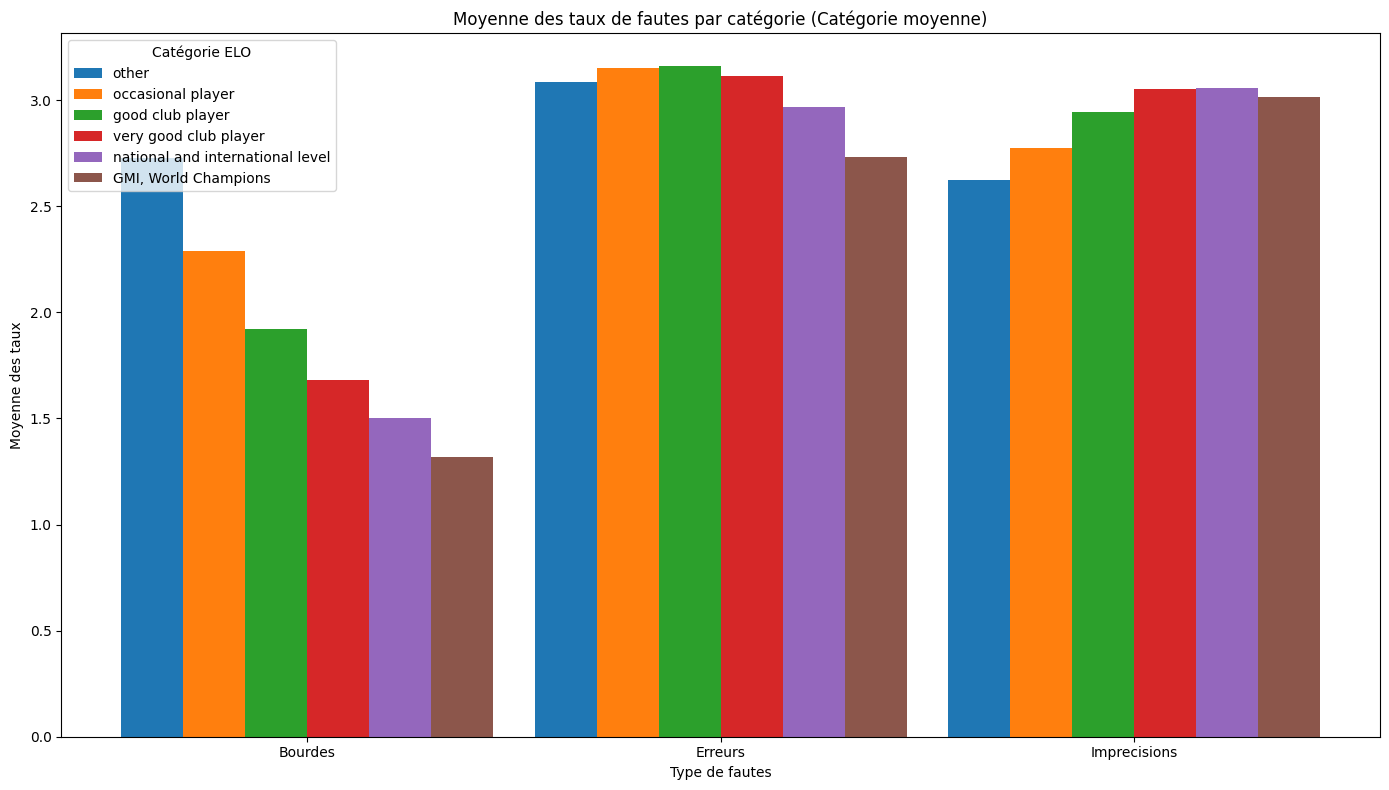

In [27]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.15

for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes') # TODO : Peut etre dire autrement
plt.ylabel('Moyenne des taux')
plt.title('Moyenne des taux de fautes par catégorie (Catégorie moyenne)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

#### Classification des games avec 2 joueurs de la même catégorie

In [28]:
df_same_category = df_blitz.filter(col("Black_ELO_category") == col("White_ELO_category"))

In [29]:
tot_blitz = df_blitz.count()
tot_same_cat = df_same_category.count()
print(f"Nombre de parties total : {tot_blitz}")
print(f"Nombre de parties avec 2 joueurs de la même catégorie : {tot_blitz}")
print(f"Pourcentage même catégorie : {tot_same_cat / tot_blitz * 100} %")

Nombre de parties total : 1812120
Nombre de parties avec 2 joueurs de la même catégorie : 1812120
Pourcentage même catégorie : 77.09274220250315 %


In [30]:
df_same_category_summary = df_same_category.groupBy("Black_ELO_category").agg(
    {"Black_blunders": "avg", "White_blunders": "avg",
     "Black_mistakes": "avg", "White_mistakes": "avg",
     "Black_inaccuracies": "avg", "White_inaccuracies": "avg",
     "Total_moves": "avg"}
).withColumnRenamed("avg(Black_blunders)", "Avg_Black_Blunders") \
 .withColumnRenamed("avg(White_blunders)", "Avg_White_Blunders") \
 .withColumnRenamed("avg(Black_mistakes)", "Avg_Black_Mistakes") \
 .withColumnRenamed("avg(White_mistakes)", "Avg_White_Mistakes") \
 .withColumnRenamed("avg(Black_inaccuracies)", "Avg_Black_Inaccuracies") \
 .withColumnRenamed("avg(White_inaccuracies)", "Avg_White_Inaccuracies") \
 .withColumnRenamed("avg(Total_moves)", "Avg_Total_Moves")

In [31]:
df_same_category_summary_pandas = df_same_category_summary.toPandas()

In [32]:
# TODO : Voir si on affiche les other

# Ordonner les catégories de joueurs
category_order = ["other", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions"]
df_avg_elo_summary_pandas['Avg_ELO_category'] = pd.Categorical(df_avg_elo_summary_pandas['Avg_ELO_category'],  categories=category_order,  ordered=True)
df_avg_elo_summary_pandas = df_avg_elo_summary_pandas.sort_values('Avg_ELO_category')


categories = df_avg_elo_summary_pandas['Avg_ELO_category']
error_types = ['Bourdes', 'Erreurs', 'Imprecisions']

# Données par type d'erreur et catégorie (moyenne) # TODO : Voir si on fait autrement
blunders = df_avg_elo_summary_pandas[['Avg_Black_Blunders', 'Avg_White_Blunders']].mean(axis=1)
mistakes = df_avg_elo_summary_pandas[['Avg_Black_Mistakes', 'Avg_White_Mistakes']].mean(axis=1)
inaccuracies = df_avg_elo_summary_pandas[['Avg_Black_Inaccuracies', 'Avg_White_Inaccuracies']].mean(axis=1)

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

In [33]:
# TODO : Voir si on affiche les other

# Ordonner les catégories de joueurs
category_order = ["other", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions"]

df_same_category_summary_pandas['Black_ELO_category'] = pd.Categorical(df_same_category_summary_pandas['Black_ELO_category'],  categories=category_order,  ordered=True)
df_same_category_summary_pandas = df_same_category_summary_pandas.sort_values('Black_ELO_category')


In [34]:
# Données par type d'erreur et catégorie (moyenne) # TODO : Voir si on fait autrement
blunders = df_same_category_summary_pandas[['Avg_Black_Blunders', 'Avg_White_Blunders']].mean(axis=1)
mistakes = df_same_category_summary_pandas[['Avg_Black_Mistakes', 'Avg_White_Mistakes']].mean(axis=1)
inaccuracies = df_same_category_summary_pandas[['Avg_Black_Inaccuracies', 'Avg_White_Inaccuracies']].mean(axis=1)

error_types = ['Bourdes', 'Erreurs', 'Imprecisions']
categories = df_same_category_summary_pandas['Black_ELO_category']

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

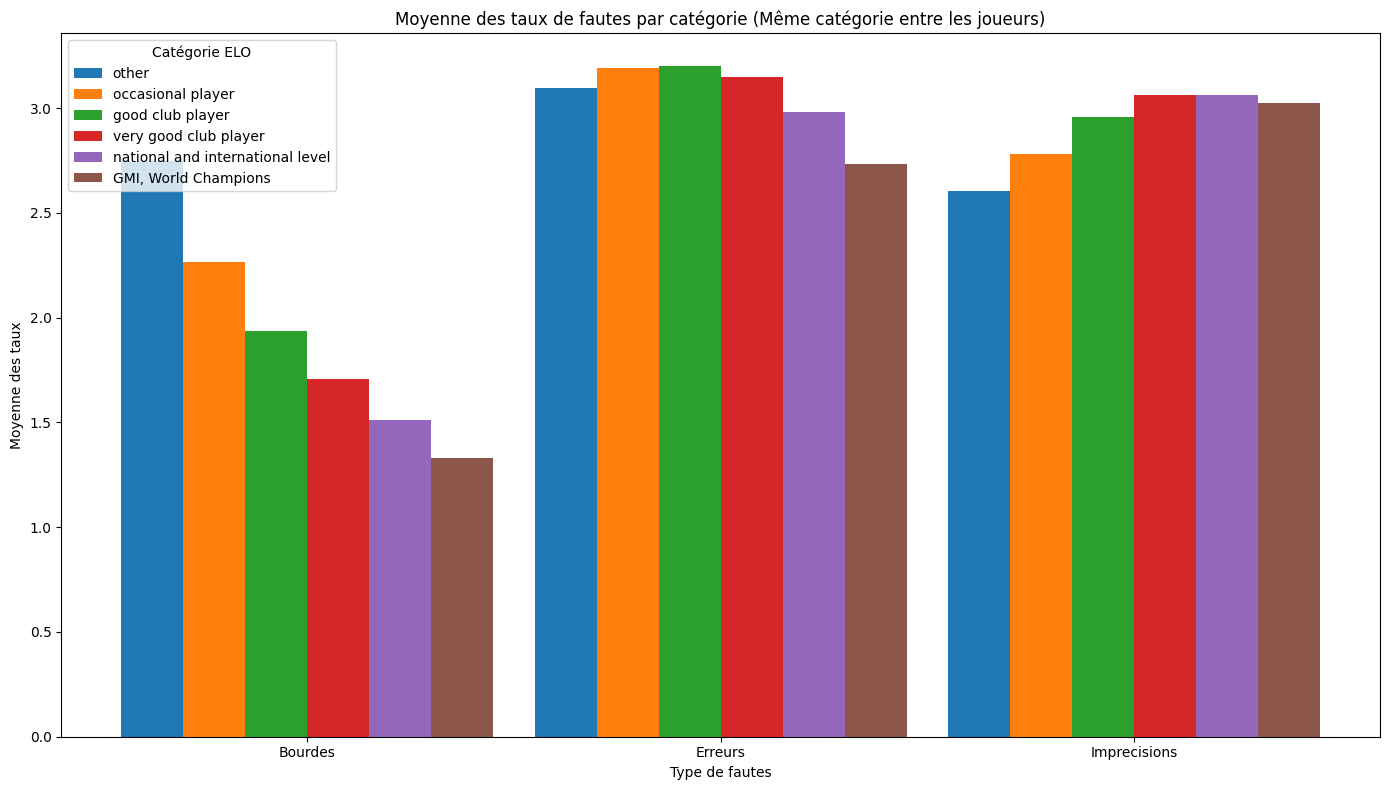

In [35]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.15
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes') # TODO : Peut etre dire autrement
plt.ylabel('Moyenne des taux')
plt.title('Moyenne des taux de fautes par catégorie (Même catégorie entre les joueurs)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

#### Résultats

- Même résultats par moyenne ou seulement les joueurs ayant la même catégorie.
- Bourdes diminue avec le niveaux
- Type de faute augmente un peu puis diminue
- Imprécisions augmente

=> Regarder la vitesse de jeu qui pourrait faire que les imprécisions augmentent car ils jouent plus vites ?


In [36]:
# TODO : Parler des résultats
# Peut etre refaire d'autres graphiques

### Question 2

Q2: Win probability depending on opening:

Q2a: With which opening does White have the best chance to win, by level category (*) and by type of game (Blitz, Fast, Classic).
Q2b: same question with black. You don't need to write again the same but only the results with black.

In [37]:
# TODO : Ici

## Idées questions supplémentaires

- influence of time spent per move on errors
  - existe t il une corrélation entre le temps moyen par coup et le nombre d'erreurs ?
  - analyse par niveau et type de jeu

- distribtion of drawn games by opening and level
  - quelles ouvertures ont une probabilité plus élevée de conduire à une partie nulle ?
  - analyse des taux de parties nulles en fonciton de l'ouverture et des catégories ELO

- impact of ELO difference on game length
  - les parties avec une grande différence d'ELO durent-elles moins longtemps (en nombre de coups) ?

- most common mistakes by level
  - quels types d'erreurs sont les plus fréquents selon les catégories ELO ?
  - comparaison entre joueurs de niveau débutant et expert

- optimal strategy for specific openings
  - pour une ouverture donnée (à sélectionner manuellement), quelle est la stratégie optiale selon le niveau des joueurs ?